### MTCNN
- 사전 학습 모델 그대로 사용
- `MTCNN().detect_faces(image)`

In [ ]:
# mtcnn = MTCNN()
# faces = mtcnn.detect_faces(image)
# 단일 이미지에서 여러 얼굴 탐지 가능

# 출력 예시
'''[
    {
        'box': [100, 150, 50, 50],  # x_min, y_min, width, height
        'confidence': 0.99,
        'keypoints': {
            'left_eye': (120, 170),
            'right_eye': (140, 170),
            'nose': (130, 180),
            'mouth_left': (120, 200),
            'mouth_right': (140, 200)
        }
    },
    ...
]'''


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

2024-12-22 10:20:48.173495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 10:20:48.173549: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 10:20:48.173583: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 데이터 로드

# 원본 데이터
df_train = pd.read_csv('/workspace/#Ub370#Uc774#Ud130/Data/label/train/train.csv')
df_val = pd.read_csv('/workspace/#Ub370#Uc774#Ud130/Data/label/val/val.csv')
df_test = pd.read_csv('/workspace/#Ub370#Uc774#Ud130/test/label/test.csv')

# 증강 데이터
df_albumentation = pd.read_csv('/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train.csv')
df_mask_boxout = pd.read_csv('/workspace/Data_Augumentation/out_box_masking/label/train/mask_boxout.csv')
df_crop_face = pd.read_csv('/workspace/Data_Augumentation/segmentation_face/label/train/face_only_train.csv')

In [3]:
# 이미지, label 로드 함수 정의
def load_image_data(data, target_size=(224, 224)):
    images = []
    boxes = []
    for _, row in data.iterrows():
        img_path = row['path'] + row['filename']
        bbox = [row['minX'], row['minY'], row['maxX'], row['maxY']]

        try:
            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError(f"Image not found at {img_path}")

            original_height, original_width = img.shape[:2]
            img_resized = cv2.resize(img, target_size)

            # 바운딩 박스 좌표 정규화
            scale_x = target_size[1] / original_width
            scale_y = target_size[0] / original_height
            normalized_bbox = [
                int(bbox[0] * scale_x),  # minX
                int(bbox[1] * scale_y),  # minY
                int(bbox[2] * scale_x),  # maxX
                int(bbox[3] * scale_y),  # maxY
            ]

            images.append(img_resized)
            boxes.append(normalized_bbox)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(boxes)



In [4]:
# 예측 함수 정의
def predict_bounding_boxes(images, detector, target_size=(224, 224)):
    predicted_boxes = []
    for img in images:
        try:
            # MTCNN을 통해 얼굴 감지
            detections = detector.detect_faces(img)
            if len(detections) > 0:
                # 첫 번째 얼굴의 바운딩 박스 사용 (다중 얼굴 처리 시 추가 로직 필요)
                bbox = detections[0]['box']
                x, y, w, h = bbox

                # 바운딩 박스 정규화 (224x224 기준)
                normalized_bbox = [
                    max(0, int(x)),                     # minX
                    max(0, int(y)),                     # minY
                    min(target_size[1], int(x + w)),    # maxX
                    min(target_size[0], int(y + h)),    # maxY
                ]
            else:
                # 얼굴이 감지되지 않으면 빈 값 저장
                normalized_bbox = [0, 0, 0, 0]

            predicted_boxes.append(normalized_bbox)
        except Exception as e:
            print(f"Error predicting bounding box: {e}")
            predicted_boxes.append([0, 0, 0, 0])  # 예외 시 빈 값 추가

    return np.array(predicted_boxes)

In [11]:
# 결과 시각화 함수 
def visualize_predictions(images, true_boxes, predicted_boxes):
    for i in range(10):             # 10개만 시각화
    # for i in range(len(images)):
        img = images[i]
        true_box = true_boxes[i]
        pred_box = predicted_boxes[i]

        plt.figure()
        plt.imshow(img / 255.0)

        # 실제 박스 그리기
        if true_box is not None:
            plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]),
                                              true_box[2] - true_box[0],
                                              true_box[3] - true_box[1],
                                              fill=False, color='green', linewidth=2, label='True Box'))
        # 예측 박스 그리기
        if pred_box is not None:
            plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]),
                                              pred_box[2] - pred_box[0],
                                              pred_box[3] - pred_box[1],
                                              fill=False, color='red', linewidth=2, label='Predicted Box'))

        plt.legend()
        plt.show()

In [6]:
# IoU 계산 함수
def calculate_iou(box1, box2):
    # box = [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Intersection 영역
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # 각 박스 면적
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    # Union 영역
    union_area = box1_area + box2_area - intersection_area
    
    # IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

# 성능 평가 함수
def evaluate_boxes(true_boxes, predicted_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    for true_box in true_boxes:
        matched = False
        for pred_box in predicted_boxes:
            iou = calculate_iou(true_box, pred_box)
            if iou >= iou_threshold:
                tp += 1
                matched = True
                break
        if not matched:
            fn += 1
    fp = len(predicted_boxes) - tp
    return {
        "Precision": tp / (tp + fp) if tp + fp > 0 else 0,
        "Recall": tp / (tp + fn) if tp + fn > 0 else 0,
        "F1-Score": (2 * tp / (2 * tp + fp + fn)) if tp + fp + fn > 0 else 0
    }


In [ ]:
# 데이터 로드
images, true_boxes = load_image_data(df_test)

# MTCNN 모델 초기화
detector = MTCNN()

# MTCNN 예측 실행 후 예측 바운딩 박스 저장
predicted_boxes = predict_bounding_boxes(images, detector)



Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

In [ ]:
# 예측 결과 평가
IoU_threshold = 0.7
metrics = evaluate_boxes(true_boxes, predicted_boxes, IoU_threshold)
print(metrics)

{'Precision': 0.7875, 'Recall': 0.7875, 'F1-Score': 0.7875}


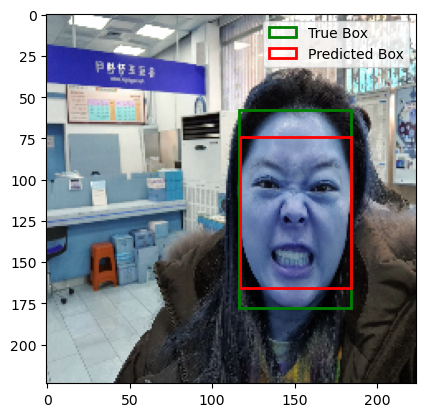

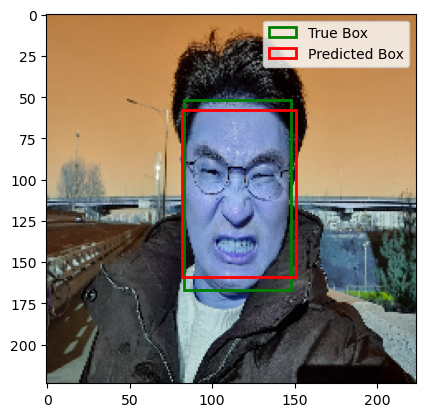

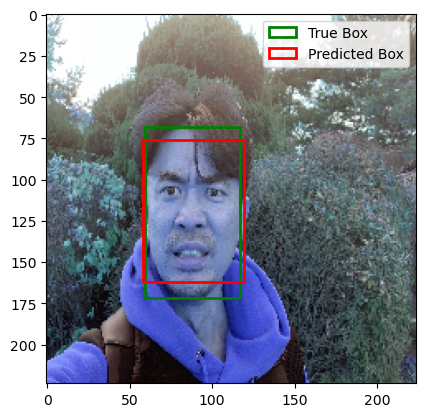

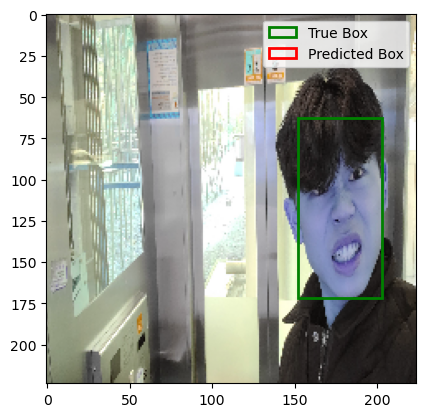

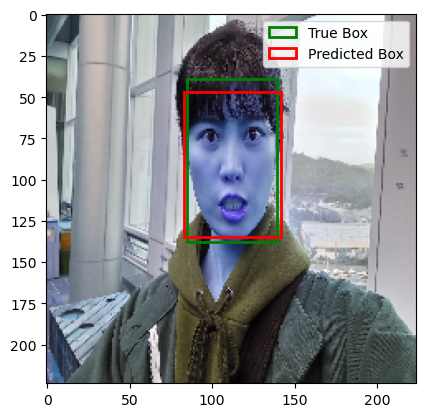

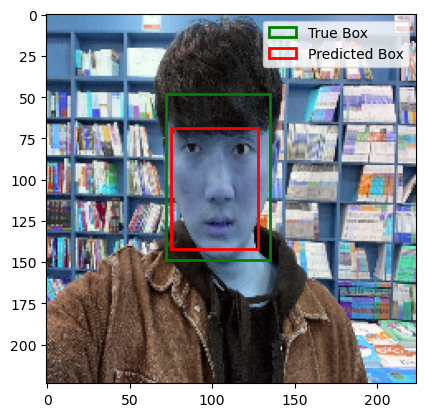

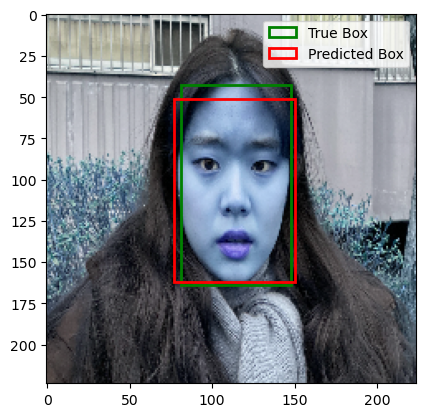

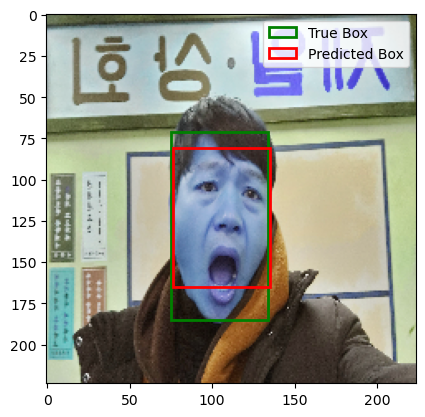

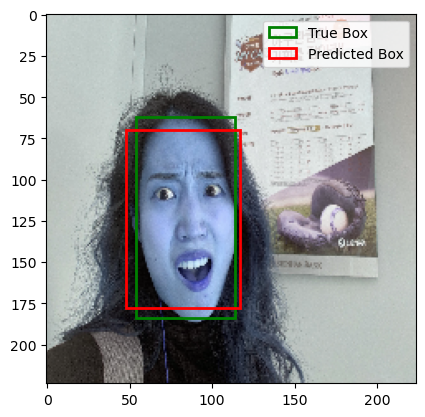

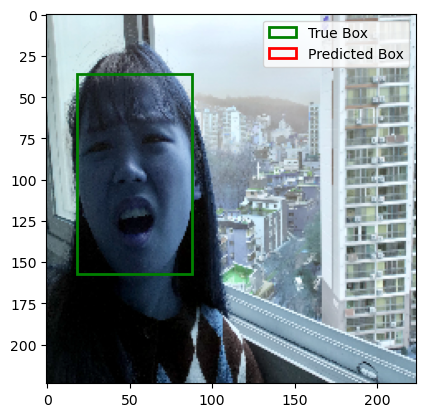

In [12]:
# 시각화
visualize_predictions(images, true_boxes, predicted_boxes)